<a href="https://colab.research.google.com/github/VansheekaPachauree/Sentiment-Analysis-Topic-Modelling/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

import gspread
import google.auth

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
credentials, project_id = google.auth.default()
gc = gspread.Client(auth=credentials)

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1NMyDwpqI7FQ6LzMxpzVdqaOGmxEfLmwzaF8H2Wg74ic/edit?gid=0#gid=0'
sheet = gc.open_by_url(sheet_url)
worksheet = sheet.sheet1
data = worksheet.get_all_records()

In [ ]:
apple_df = pd.DataFrame(data)

In [ ]:
apple_df.columns

Index(['date', 'target', 'text', 'clean_text', 'date_no_tz', 'clean_date',
       'Sentiment'],
      dtype='object')

In [ ]:
df = apple_df[['clean_text', 'Sentiment']].dropna().copy()

In [ ]:
df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower()

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
negative,8783
neutral,7069
positive,5619


In [ ]:
def fit_lda(texts, n_topics=6):
    vectorizer = CountVectorizer(
        stop_words="english",
        max_df=0.85,
        min_df=10,
        max_features=6000,
        ngram_range=(1, 2)
    )
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method="batch"
    )
    doc_topic = lda.fit_transform(X)

    return lda, vectorizer, doc_topic

In [ ]:
def print_topics(lda_model, vectorizer, n_top_words=12):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")

In [ ]:
models = {}

for s in ['negative', 'neutral', 'positive']:
    texts = df.loc[df['Sentiment'] == s, 'clean_text'].astype(str)
    lda, vec, doc_topic = fit_lda(texts, n_topics=6)

    models[s] = {"lda": lda, "vec": vec, "doc_topic": doc_topic}

    print(f"\n===== {s.upper()} TOPICS =====")
    print_topics(lda, vec, n_top_words=12)


===== NEGATIVE TOPICS =====
Topic 1: iphone, doesnt, work, os, app, 30, safari, wont, tweetdeck, os 30, doesnt work, trying
Topic 2: ipod, just, touch, im, ipod touch, music, lost, died, itunes, new, dead, isnt
Topic 3: iphone, update, 30, itunes, iphone 30, apps, 3g, just, software, want, iphone 3g, im
Topic 4: like, mac, dont, im, time, machine, know, going, having, itunes, looks, sorry
Topic 5: iphone, new, 3gs, new iphone, dont, machine, just, im, want, think, iphone 3gs, washing
Topic 6: mac, macbook, im, just, apple, store, got, really, want, machine, pro, apple store

===== NEUTRAL TOPICS =====
Topic 1: itunes, store, mac, apple, im, apple store, just, going, app, download, app store, right
Topic 2: macbook, new, itunes, lol, ipod, im, work, just, way, songs, pro, ill
Topic 3: iphone, new, new iphone, 3gs, app, just, update, 3g, dont, im, want, squarespace
Topic 4: mac, iphone, os, think, use, version, iphone os, using, safari, os 30, just, windows
Topic 5: iphone, 30, got, itu

In [ ]:
def plot_top_words(lda_model, vectorizer, topic_idx, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    topic = lda_model.components_[topic_idx]
    top_indices = topic.argsort()[::-1][:n_top_words]

    words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]

    plt.figure()
    plt.barh(words[::-1], weights[::-1])
    plt.title(f"Topic {topic_idx + 1} – Top Words")
    plt.xlabel("Word Weight")
    plt.tight_layout()
    plt.show()

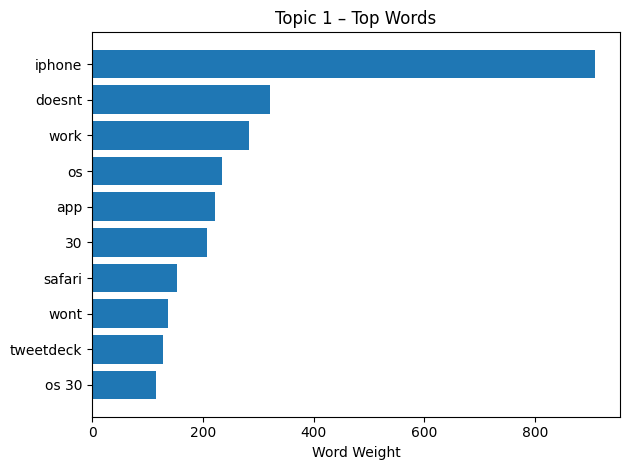

In [ ]:
plot_top_words(models['negative']['lda'], models['negative']['vec'], topic_idx=0)

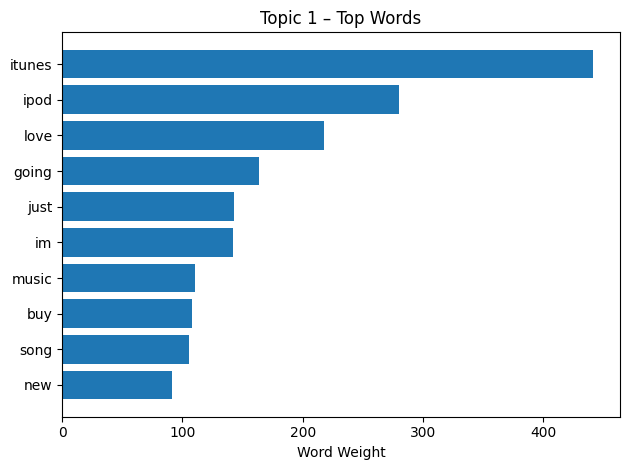

In [ ]:
plot_top_words(models['positive']['lda'], models['positive']['vec'], topic_idx=0)

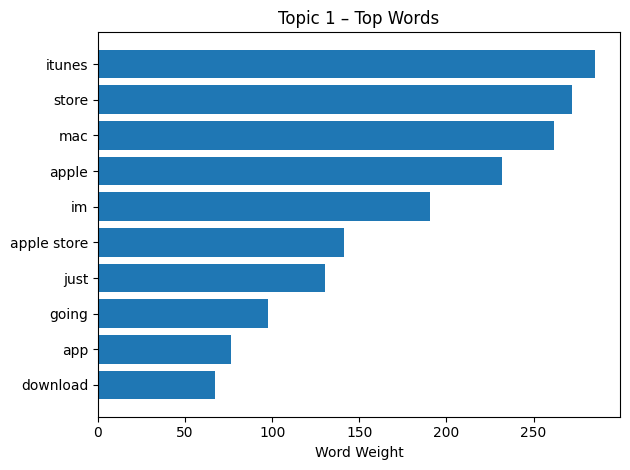

In [ ]:
plot_top_words(models['neutral']['lda'], models['neutral']['vec'], topic_idx=0)

In [ ]:
def plot_topic_distribution(doc_topic, sentiment_label):
    topic_counts = np.bincount(doc_topic.argmax(axis=1))

    plt.figure()
    plt.bar(range(len(topic_counts)), topic_counts)
    plt.xlabel("Topic")
    plt.ylabel("Number of Tweets")
    plt.title(f"Topic Distribution – {sentiment_label.capitalize()} Sentiment")
    plt.tight_layout()
    plt.show()

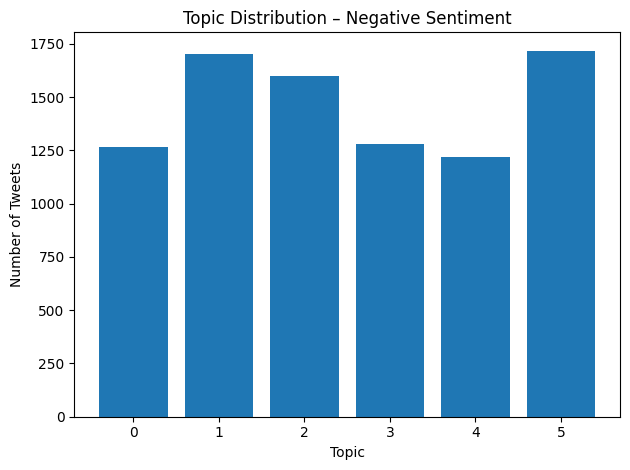

In [ ]:
plot_topic_distribution(models['negative']['doc_topic'], "negative")

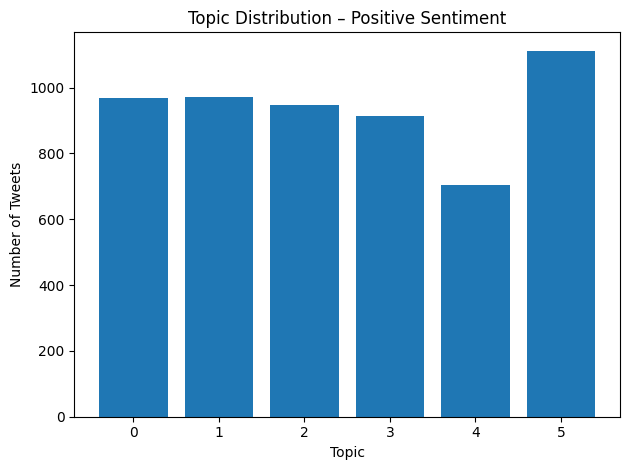

In [ ]:
plot_topic_distribution(models['positive']['doc_topic'], "positive")

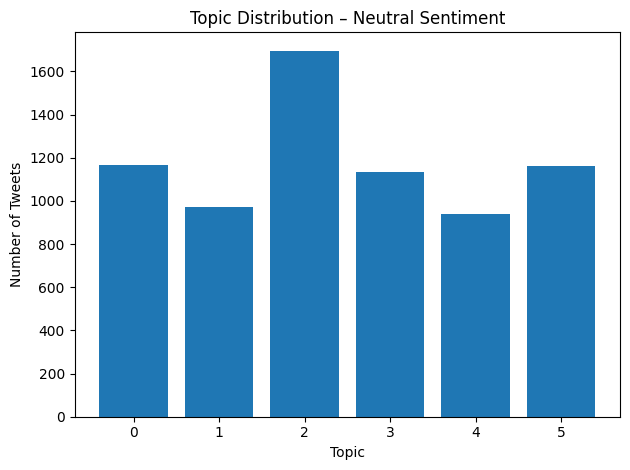

In [ ]:
plot_topic_distribution(models['neutral']['doc_topic'], "neutral")

In [ ]:
def plot_topic_heatmap(doc_topic, n_docs=50):
    subset = doc_topic[:n_docs]
    plt.figure()
    plt.imshow(subset, aspect='auto')
    plt.colorbar(label="Topic Probability")
    plt.xlabel("Topic")
    plt.ylabel("Document")
    plt.title("Document–Topic Distribution (Sample)")
    plt.show()

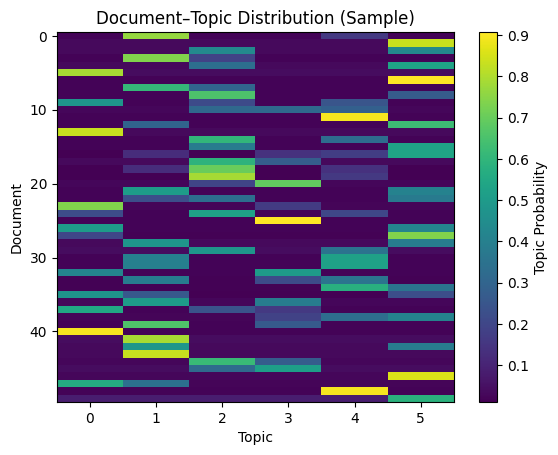

In [ ]:
plot_topic_heatmap(models['negative']['doc_topic'])

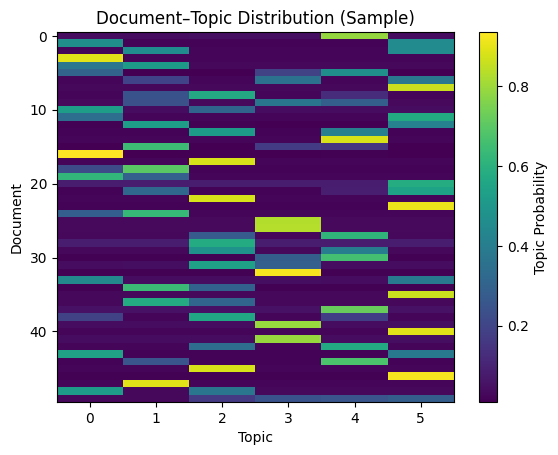

In [ ]:
plot_topic_heatmap(models['positive']['doc_topic'])

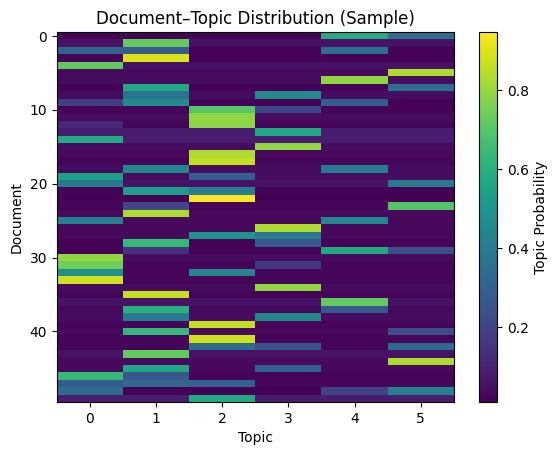

In [ ]:
plot_topic_heatmap(models['neutral']['doc_topic'])